In [6]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
from scipy.linalg import ishermitian, expm
from multiprocessing import Pool, cpu_count
import scipy.integrate as integrate
import time
from concurrent.futures import ProcessPoolExecutor

<h2>OBC 2-drive SSH</h2>

In [7]:
def twodriveSSH_obc(u, v, a1, a2, phi, k, t):
    U1 = lambda t: u*(1 + 2*np.cos(w1*t) + a1*np.cos(w2*t))
    U2 = lambda t: v*(1 - 2*np.cos(w1*t) + a1*np.cos(w2*t))
    Va = lambda t: a2*(np.cos(w1*t + phi) + a1*np.cos(w2*t + phi))
    Vb = lambda t: a2*(np.cos(w1*t + phi) - a1*np.cos(w2*t + phi))
    m = [[2*Va(t)*np.cos(k), U1(t) + U2(t)*np.cos(k) - 1j*U2(t)*np.sin(k)],[U1(t) + U2(t)*np.cos(k) + 1j*U2(t)*np.sin(k), 2*Vb(t)*np.cos(k)]]
    return np.array(m)

def dh1t(u, v, a1, a2, phi, k, t):
    U1 = lambda t: u*(-2*w1*np.sin(w1*t))
    U2 = lambda t: v*(2*w1*np.sin(w1*t))
    Va = lambda t: a2*(-1*w1*np.sin(w1*t + phi))
    Vb = lambda t: a2*(-1*w1*np.sin(w1*t + phi))
    m = [[2*Va(t)*np.cos(k), U1(t) + U2(t)*np.cos(k) - 1j*U2(t)*np.sin(k)],[U1(t) + U2(t)*np.cos(k) + 1j*U2(t)*np.sin(k), 2*Vb(t)*np.cos(k)]]
    return np.array(m)
def dh2t(u, v, a1, a2, phi, k, t):
    U1 = lambda t: u*(-1*w2*a1*np.sin(w2*t))
    U2 = lambda t: v*(-1*w2*a1*np.sin(w2*t))
    Va = lambda t: a2*(-1*w2*a1*np.sin(w2*t + phi))
    Vb = lambda t: a2*(-1*w2*a1*np.sin(w2*t + phi))
    m = [[2*Va(t)*np.cos(k), U1(t) + U2(t)*np.cos(k) - 1j*U2(t)*np.sin(k)],[U1(t) + U2(t)*np.cos(k) + 1j*U2(t)*np.sin(k), 2*Vb(t)*np.cos(k)]]
    return np.array(m)

In [8]:
def U(u, v, a1, a2, phi, k, T, dt):
    tvals = np.arange(0, T+dt, dt)
    evol = np.identity(2, dtype=complex)
    for i in tvals:
        evol = expm(-1j*dt*twodriveSSH_obc(u, v, a1, a2, phi, k, i)) @ evol
    return np.matrix(evol)

In [9]:
def work1(u, v, a1, a2, phi, k, Ti, Tf, dt, step):
    w_op = lambda s: psi0.conj().T @ U(u, v, a1, a2, phi, k, s, dt).H @ dh1t(u, v, a1, a2, phi, k, s) @ U(u, v, a1, a2, phi, k, s, dt) @ psi0
    tvals = np.arange(Ti, Tf, step)
    samples = [w_op(i).item() for i in tvals]
    res = integrate.simpson(samples, tvals)
    return res 

def work2(u, v, a1, a2, phi, k, Ti, Tf, dt, step):
    w_op = lambda s: psi0.conj().T @ U(u, v, a1, a2, phi, k, s, dt).H @ dh2t(u, v, a1, a2, phi, k, s) @ U(u, v, a1, a2, phi, k, s, dt) @ psi0
    tvals = np.arange(Ti, Tf, step)
    samples = [w_op(i).item() for i in tvals]
    res = integrate.simpson(samples, tvals)
    return res 

In [39]:
w1 = 0.1
w2 = (1+np.sqrt(5))*w1/2
u = 1
v = 1.5
phi = np.pi/10
a1 = 1
a2 = 1
dt = 0.1
step = 0.01
k = 0
psi0 = la.eigh(twodriveSSH_obc(u, v, a1, a2, phi, k, 0))[1][0]

cycles = 50
T = 2*np.pi*cycles/w1
worktime = np.arange(0,T,0.5)
dt = 0.1
step = 0.01

def compute_work1(i):
    worki = work1(u, v, a1, a2, phi, k, worktime[i], worktime[i+1], dt, step)
    with open('drive1.txt', 'a') as f1:
        f1.write(str(worki)+'\n')
    return worki

def compute_work2(i):
    worki = work2(u, v, a1, a2, phi, k, worktime[i], worktime[i+1], dt, step)
    with open('drive2.txt', 'a') as f2:
        f2.write(str(worki)+'\n')
    return worki

# start = time.perf_counter()
# drive1 = [work1(u, v, a1, a2, phi, k, worktime[i], worktime[i+1], dt, step) for i in range(len(worktime)-1)]
# drive2 = [work2(u, v, a1, a2, phi, k, worktime[i], worktime[i+1], dt, step) for i in range(len(worktime)-1)]
# end = time.perf_counter()
# print('Done in ', end-start, 'seconds')

In [40]:
len(worktime)

6284

In [42]:
start = time.perf_counter()
if __name__ == "__main__":
    with ProcessPoolExecutor() as executor:
        # drive1 = list(executor.map(compute_work1, range(len(worktime)-1)))
        drive2 = list(executor.map(compute_work2, range(len(worktime)-1)))
end = time.perf_counter()
print('Done in ', end-start, 'seconds')

KeyboardInterrupt: 

In [ ]:
drive1_t = [np.sum(drive1[:i]) for i in range(len(drive1))]
drive2_t = [np.sum(drive2[:i]) for i in range(len(drive1))]

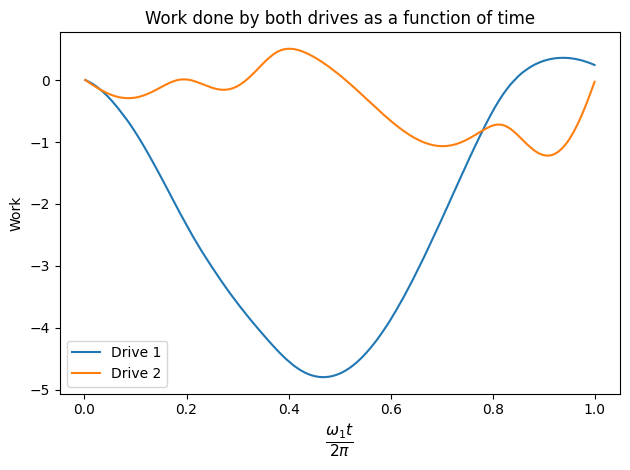

In [13]:
plt.plot(worktime[1:]*w1/(2*np.pi), np.real(drive1_t))
plt.plot(worktime[1:]*w1/(2*np.pi), np.real(drive2_t))

# plt.plot(worktime[1:]*w1/(2*np.pi), np.real(drive1))
# plt.plot(worktime[1:]*w1/(2*np.pi), np.real(drive2))
plt.legend(['Drive 1', 'Drive 2'])
plt.xlabel(r'$\frac{\omega_1 t}{2\pi}$', fontsize=16)
plt.ylabel('Work')
plt.title('Work done by both drives as a function of time')
plt.tight_layout()
plt.show()

In [48]:
drive1f = np.loadtxt('drive1.txt', dtype=complex)
drive2f = np.loadtxt('drive2.txt', dtype=complex)

In [51]:
print(len(drive1f), len(drive2f), len(worktime))

3891 3930 6284


In [52]:
drive1_t = [np.sum(drive1f[:i]) for i in range(len(drive1f))]
drive2_t = [np.sum(drive2f[:i]) for i in range(len(drive1f))]

In [57]:
print(len(drive1_t), len(drive2_t), len(worktime[1:3892]))

3891 3891 3891


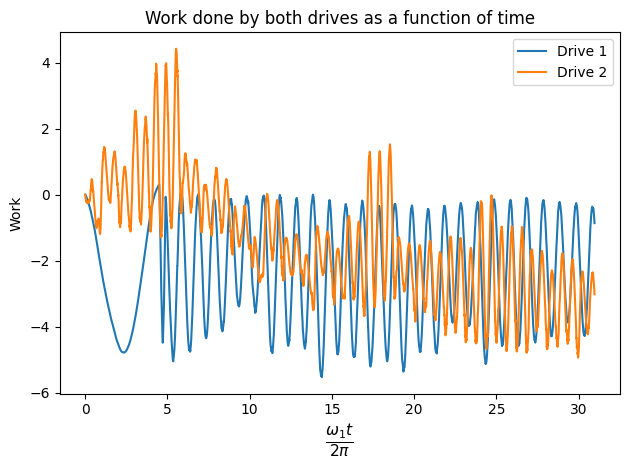

In [58]:
plt.plot(worktime[1:3892]*w1/(2*np.pi), np.real(drive1_t))
plt.plot(worktime[1:3892]*w1/(2*np.pi), np.real(drive2_t))

# plt.plot(worktime[1:]*w1/(2*np.pi), np.real(drive1))
# plt.plot(worktime[1:]*w1/(2*np.pi), np.real(drive2))
plt.legend(['Drive 1', 'Drive 2'])
plt.xlabel(r'$\frac{\omega_1 t}{2\pi}$', fontsize=16)
plt.ylabel('Work')
plt.title('Work done by both drives as a function of time')
plt.tight_layout()
plt.show()

<h2>Finite size (N unit cells) 2-drive SSH</h2>
Hamiltonian of a 2-drive SSH model with intracell, NN intercell hoppings and NNN intercell hoppings. (From Olin et al)

In [2]:
def twodriveSSH_finite(N, w1, w2, u, v, a1, a2, phi, t):
    U1 = lambda t: u*(1 + 2*np.cos(w1*t) + a1*np.cos(w2*t))
    U2 = lambda t: v*(1 - 2*np.cos(w1*t) + a1*np.cos(w2*t))
    Va = lambda t: a2*(np.cos(w1*t + phi) + a1*np.cos(w2*t + phi))
    Vb = lambda t: a2*(np.cos(w1*t + phi) - a1*np.cos(w2*t + phi))

    ham = []
    for i in range(N):
        row = []
        for j in range(N):
            if(i==j):
                m = np.array([[0, U1(t)],[U1(t), 0]])
                row.append(m)
            elif (np.abs(i-j) == 1):
                m = np.array([[Va(t), U2(t)],[U2(t), Vb(t)]])
                row.append(m)
            else:
                m = np.array([[0,0],[0,0]])
                row.append(m)
        ham.append(row)
    return np.block(ham)

def dh1t(N, w1, w2, u, v, a1, a2, phi, t):
    U1 = lambda t: u*(-2*w1*np.sin(w1*t))
    U2 = lambda t: v*(2*w1*np.sin(w1*t))
    Va = lambda t: a2*(-1*w1*np.sin(w1*t + phi))
    Vb = lambda t: a2*(-1*w1*np.sin(w1*t + phi))

    ham = []
    for i in range(N):
        row = []
        for j in range(N):
            if(i==j):
                m = np.array([[0, U1(t)],[U1(t), 0]])
                row.append(m)
            elif (np.abs(i-j) == 1):
                m = np.array([[Va(t), U2(t)],[U2(t), Vb(t)]])
                row.append(m)
            else:
                m = np.array([[0,0],[0,0]])
                row.append(m)
        ham.append(row)
    return np.block(ham)

def dh2t(N, w1, w2, u, v, a1, a2, phi, t):
    U1 = lambda t: u*(-1*w2*a1*np.sin(w2*t))
    U2 = lambda t: v*(-1*w2*a1*np.sin(w2*t))
    Va = lambda t: a2*(-1*w2*a1*np.sin(w2*t + phi))
    Vb = lambda t: a2*(-1*w2*a1*np.sin(w2*t + phi))

    ham = []
    for i in range(N):
        row = []
        for j in range(N):
            if(i==j):
                m = np.array([[0, U1(t)],[U1(t), 0]])
                row.append(m)
            elif (np.abs(i-j) == 1):
                m = np.array([[Va(t), U2(t)],[U2(t), Vb(t)]])
                row.append(m)
            else:
                m = np.array([[0,0],[0,0]])
                row.append(m)
        ham.append(row)
    return np.block(ham)

In [3]:
def U(N, w1, w2, u, v, a1, a2, phi, T, dt):
    tvals = np.arange(0, T+dt, dt)
    evol = np.identity(2*N, dtype=complex)
    for i in tvals:
        m = twodriveSSH_finite(N, w1, w2, u, v, a1, a2, phi, i)
        evol = expm(-1j*dt*m ) @ evol
    return np.matrix(evol)

In [4]:
 def work1(N, w1, w2, u, v, a1, a2, phi, Ti, Tf, dt, step):
    psi0 = la.eigh(twodriveSSH_finite(N, w1, w2, u, v, a1, a2, phi, 0))[1][0]    
    w_op = lambda s: psi0.conj().T @ U(N, w1, w2, u, v, a1, a2, phi, s, dt).H @ dh1t(N, w1, w2, u, v, a1, a2, phi, s) @ U(N, w1, w2, u, v, a1, a2, phi, s, dt) @ psi0
    tvals = np.arange(Ti, Tf, step)
    samples = [w_op(i).item() for i in tvals]
    res = integrate.simpson(samples, tvals)
    return res 

 def work2(N, w1, w2, u, v, a1, a2, phi, Ti, Tf, dt, step):
    psi0 = la.eigh(twodriveSSH_finite(N, w1, w2, u, v, a1, a2, phi, 0))[1][0]    
    w_op = lambda s: psi0.conj().T @ U(N, w1, w2, u, v, a1, a2, phi, s, dt).H @ dh2t(N, w1, w2, u, v, a1, a2, phi, s) @ U(N, w1, w2, u, v, a1, a2, phi, s, dt) @ psi0
    tvals = np.arange(Ti, Tf, step)
    samples = [w_op(i).item() for i in tvals]
    res = integrate.simpson(samples, tvals)
    return res 

In [ ]:
# N, w1, w2, u, v, a1, a2, phi, Ti, Tf, dt, step
N = 10
w1 = 0.1
w2 = (1+np.sqrt(5))*w1/2
u = 1
v = 1.5
phi = np.pi/10
a1 = 1
a2 = 1
dt = 0.1
step = 0.01

start = time.perf_counter()

cycles = 30
T = 2*np.pi*cycles/w1
worktime = np.arange(0,T,0.1)
dt = 0.1
step = 0.01

drive1 = [work1(N, w1, w2, u, v, a1, a2, phi, worktime[i], worktime[i+1], dt, step) for i in range(len(worktime)-1)]
drive2 = [work2(N, w1, w2, u, v, a1, a2, phi, worktime[i], worktime[i+1], dt, step) for i in range(len(worktime)-1)]
end = time.perf_counter()
print("Done!")

In [ ]:
print(end - start, 'seconds')

In [ ]:
drive1_t = [np.sum(drive1[:i]) for i in range(len(drive1))]
drive2_t = [np.sum(drive2[:i]) for i in range(len(drive1))]

In [ ]:
plt.plot(worktime[1:],np.real(drive1))
plt.plot(worktime[1:],np.real(drive2))
plt.show()

In [ ]:
# def w1_op(args):
#     N, w1, w2, u, v, a1, a2, phi, s, dt = args
#     psi0 = la.eigh(twodriveSSH_finite(N, w1, w2, u, v, a1, a2, phi, 0))[1][0]
#     return (
#         psi0.conj().T
#         @ U(N, w1, w2, u, v, a1, a2, phi, s, dt).conj().T
#         @ dh1t(N, w1, w2, u, v, a1, a2, phi, s)
#         @ U(N, w1, w2, u, v, a1, a2, phi, s, dt)
#         @ psi0
#     ).item()

# def work1(N, w1, w2, u, v, a1, a2, phi, Ti, Tf, dt, step):
#     tvals = np.linspace(Ti, Tf, int((Tf-Ti)/step)+1)

#     # pack parameters into tuples for each s
#     args_list = [(N, w1, w2, u, v, a1, a2, phi, s, dt) for s in tvals]

#     with Pool(processes=cpu_count()) as pool:
#         samples = pool.map(w1_op, args_list)

#     res = integrate.simpson(samples, tvals)
#     return res

# def w2_op(args):
#     N, w1, w2, u, v, a1, a2, phi, s, dt = args
#     psi0 = la.eigh(twodriveSSH_finite(N, w1, w2, u, v, a1, a2, phi, 0))[1][0]
#     return (
#         psi0.conj().T
#         @ U(N, w1, w2, u, v, a1, a2, phi, s, dt).conj().T
#         @ dh2t(N, w1, w2, u, v, a1, a2, phi, s)
#         @ U(N, w1, w2, u, v, a1, a2, phi, s, dt)
#         @ psi0
#     ).item()

# def work2(N, w1, w2, u, v, a1, a2, phi, Ti, Tf, dt, step):
#     tvals = np.linspace(Ti, Tf, int((Tf-Ti)/step)+1)

#     # pack parameters into tuples for each s
#     args_list = [(N, w1, w2, u, v, a1, a2, phi, s, dt) for s in tvals]

#     with Pool(processes=cpu_count()) as pool:
#         samples = pool.map(w2_op, args_list)

#     res = integrate.simpson(samples, tvals)
#     return res